# SOO Experiment design

We show how to design your experiment when you only care about 1 thing - minimising the loss of the experiment assuming none of the sensors fail. This is single objective optimisation.

In [1]:
%matplotlib inline
import sys
import os

# Sort the paths out to run from this file
parent_path = os.path.dirname(os.getcwd())
src_path = os.path.join(os.path.sep,parent_path, 'src')
sys.path.append(src_path)
print(src_path)

/home/dharrington/cyclops/src


## Design a 2D scalar field experiment with no assumptions with SOO

We load the correct field file and grid file that we generated in step 1.

We then define the region that the sensors can be placed in (no less than 2 mm from the monoblock edges).

We setup the sensor suite after defining that the sensors will have zero systematic error at any temperature. The sensor suite requires an input field type to allow it to predict the values of an entire field based off the sensor values it is given.

We setup the experiment and define its optimiser and use the grid of comparison positions defined in step 1. 

Finally we display the results.

Things to change
1. Names of the `field_temp.obj` and `grid_temp.obj` if you want new fields and grids that you defined in step 1
2. The sensor bounds
3. The systematic error function does not have to be `def f(x): return 0`
4. You can add in symmetry assumptions (see next example)
5. The optimise can be changed (note that this is single objective optimisation to minimise the loss only so only single objective optimisers can be used)
6. Swap out the model used in the field of the `SensorSuite` for a different ML regression model to see what kind of job that does.

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       30 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  6.622005E+04 |  1.056293E+04
     2 |       60 |  0.44426 |       2 |  0.6791 |  2.03139 |  1.96861 |  4.837986E+04 |  1.056293E+04
     3 |       90 |  0.12780 |       3 |  0.4817 |  2.03088 |  1.98568 |  3.255205E+04 |  1.056293E+04
     4 |      120 |  0.02926 |       3 |  0.4184 |  2.02218 |  1.99666 |  2.598867E+04 |  8.343772E+03
     5 |      150 | -1.5E-02 |       3 |  0.3907 |  2.01248 |  2.00943 |  1.936161E+04 |  6.399222E+03
     6 |      180 | -2.2E-02 |       3 |  0.3861 |  2.00149 |  2.02291 |  1.627602E+04 |  4.496007E+03
     7 |      210 | -1.4E-02 |       3 |  0.3910 |  1.98950 |  2.03006 |  1.397463E+04 |  3.688472E+03
     8 |      240 | -1.4E-02 |       3 |  0.3915 |  1.98029 |  2.04847 |  1.254278E+04 |  3.317799E+03
     9 |      270 | -1.1E-02 |       3 |  0.3930 |  1.96691 |  2.06268 | 

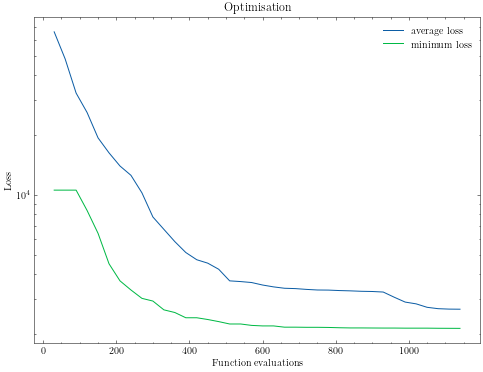

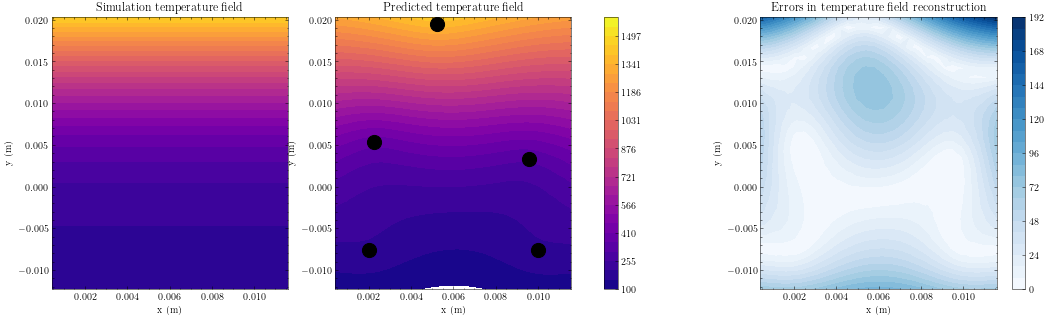

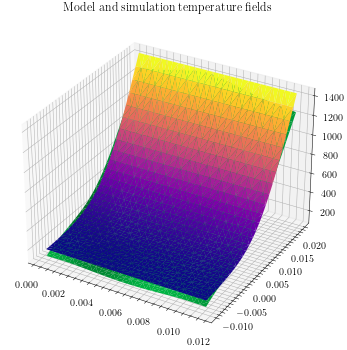

In [2]:
from run_me import *


# Load any objects necessary
pickle_manager = PickleManager()
graph_manager = GraphManager()
true_temp_field = pickle_manager.read_file('simulation', 'field_temp.obj')
grid = pickle_manager.read_file('simulation', 'grid_temp.obj')

bounds = true_temp_field.get_bounds()
sensor_bounds = bounds+np.array([[1, 1], [-1, -1]])*0.002

# Setup the sensor suite
def f(x): return 0
sensor = PointSensor(0, f, 0, [-5000, 5000])
sensors = np.array([sensor]*5)
sensor_suite = SensorSuite(
    ScalarField(RBFModel, bounds, true_temp_field.get_dim()), 
    sensors,
    symmetry=[]
)

# Setup the experiment
optimiser = PSOOptimiser('00:00:10')
experiment = Experiment(
    true_temp_field,
    grid,
    optimiser
)
experiment.plan_soo(
    sensor_suite,
    sensor_bounds
)
res = experiment.design()
proposed_layout, true_temps, model_temps, sensor_values = experiment.get_plotting_arrays(res.X)


# Display the results
graph_manager.draw(graph_manager.build_optimisation(
    res.history
))
graph_manager.draw(graph_manager.build_2D_compare(
    grid,
    proposed_layout,
    true_temps,
    model_temps
))
graph_manager.draw(graph_manager.build_3D_compare(
    grid,
    true_temps,
    model_temps
))

## Design a 2D scalar field experiment with symmetry assumptions with SOO

Now we add in symmetry assumptions. Set the x-value of the symmetry manager and then force symmetry in the line of that x value (horizontal reflection). And/or set the y-value and then force symmetry in the line of that y-value (vertical reflection). And/or set the grad-value and force symmetry in the line of that gradient of the form y=mx (line reflection). 

By combining these symmetries you can get some pretty interesting looking fields. You can also do the same for 1D fields as I'll show later.

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       30 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  3.629002E+04 |  2.579277E+03
     2 |       60 |  0.29853 |       2 |  0.5916 |  2.02624 |  1.97376 |  2.433388E+04 |  2.579277E+03
     3 |       90 |  0.09622 |       3 |  0.4613 |  2.02579 |  1.99145 |  1.487808E+04 |  2.579277E+03
     4 |      120 | -1.1E-02 |       3 |  0.3931 |  2.01685 |  2.00220 |  9.201170E+03 |  1.762167E+03
     5 |      150 |  0.03323 |       3 |  0.4209 |  2.00712 |  2.02110 |  5.256160E+03 |  1.112245E+03
     6 |      180 | -2.5E-02 |       3 |  0.3844 |  1.99320 |  2.03393 |  4.390876E+03 |  6.288666E+02
     7 |      210 | -1.9E-02 |       3 |  0.3882 |  1.98009 |  2.04245 |  3.372526E+03 |  4.503957E+02
     8 |      240 |  0.00018 |       3 |  0.4001 |  1.96942 |  2.05021 |  2.852669E+03 |  3.362965E+02
     9 |      270 | -9.1E-03 |       3 |  0.3943 |  1.96043 |  2.06007 | 

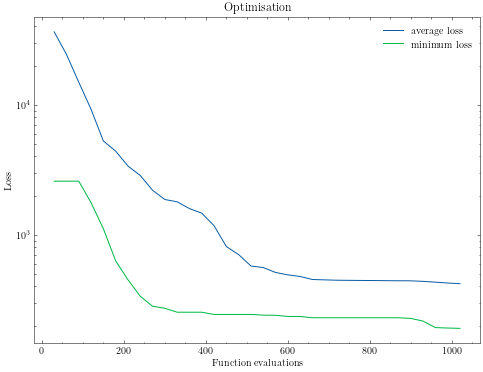

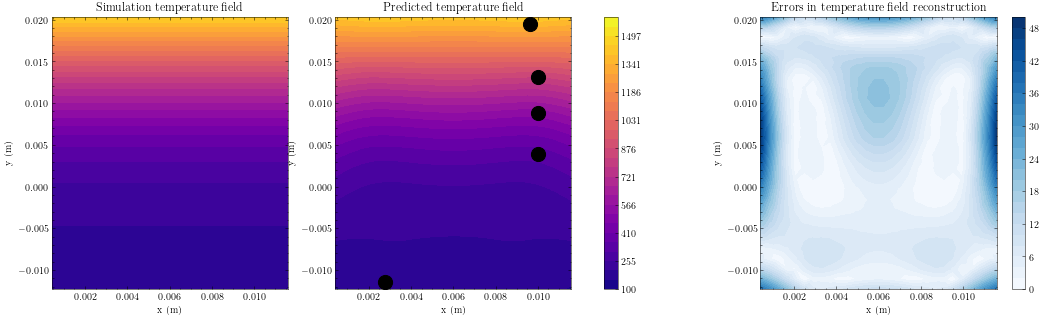

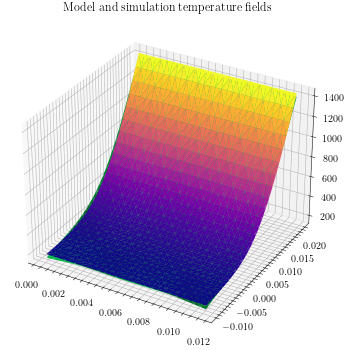

In [3]:
from run_me import *


# Load any objects necessary
pickle_manager = PickleManager()
graph_manager = GraphManager()
true_temp_field = pickle_manager.read_file('simulation', 'field_temp.obj')
grid = pickle_manager.read_file('simulation', 'grid_temp.obj')

bounds = true_temp_field.get_bounds()
sensor_bounds = bounds+np.array([[1, 1], [-1, -1]])*0.002

# Setup the symmetry
symmetry_manager = SymmetryManager()
symmetry_manager.set_2D_x(np.mean(bounds[:, 0]))

# Setup the sensor suite
def f(x): return 0
sensor = PointSensor(0, f, 0, [-5000, 5000])
sensors = np.array([sensor]*5)
sensor_suite = SensorSuite(
    ScalarField(RBFModel, bounds, true_temp_field.get_dim()), 
    sensors,
    symmetry=[symmetry_manager.reflect_2D_horiz]
)

# Setup the experiment
optimiser = PSOOptimiser('00:00:10')
experiment = Experiment(
    true_temp_field,
    grid,
    optimiser
)
experiment.plan_soo(
    sensor_suite,
    sensor_bounds
)
res = experiment.design()
proposed_layout, true_temps, model_temps, sensor_values = experiment.get_plotting_arrays(res.X)


# Display the results
graph_manager.draw(graph_manager.build_optimisation(
    res.history
))
graph_manager.draw(graph_manager.build_2D_compare(
    grid,
    proposed_layout,
    true_temps,
    model_temps
))
graph_manager.draw(graph_manager.build_3D_compare(
    grid,
    true_temps,
    model_temps
))

## Design a 1D scalar field experiment with no assumptions SOO

Now we'll do the same for a 1D experiment. Note that we can get away with using the line data as the temperature field on the 'right' monoblock face is uniform horizontally.



n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       30 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  3.498932E+04 |  1.701635E+03
     2 |       60 |  0.38932 |       2 |  0.6472 |  2.04673 |  1.95327 |  1.959487E+04 |  1.701635E+03
     3 |       90 |  0.10535 |       3 |  0.4672 |  2.04607 |  1.96810 |  1.057755E+04 |  4.230104E+02
     4 |      120 |  0.00118 |       3 |  0.4007 |  2.03790 |  1.99013 |  6.397583E+03 |  1.421472E+02
     5 |      150 |  0.00291 |       3 |  0.4018 |  2.02337 |  1.99860 |  3.890246E+03 |  1.421472E+02
     6 |      180 | -1.8E-02 |       3 |  0.3888 |  2.01210 |  2.01121 |  1.930203E+03 |  9.894865E+01
     7 |      210 | -1.5E-02 |       3 |  0.3908 |  2.00044 |  2.02431 |  1.381100E+03 |  8.391725E+01
     8 |      240 | -1.3E-02 |       3 |  0.3921 |  1.98841 |  2.04089 |  1.218646E+03 |  7.312652E+01
     9 |      270 | -1.1E-02 |       3 |  0.3931 |  1.97445 |  2.05212 | 

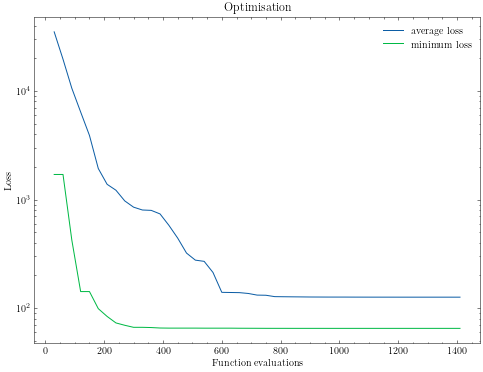

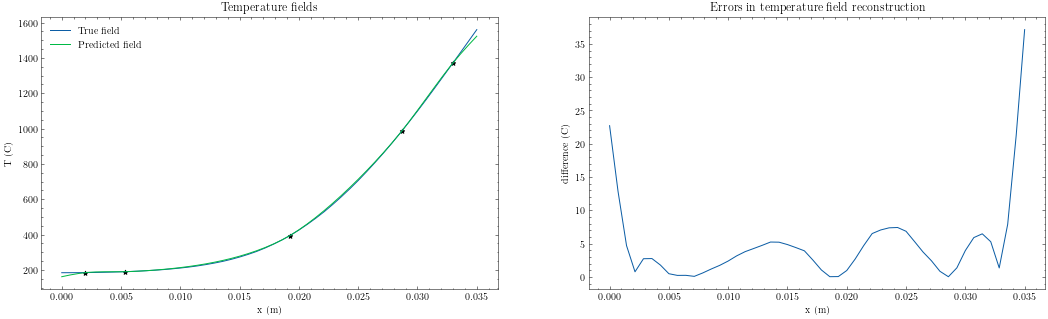

In [4]:
from run_me import *


# Load any objects necessary
pickle_manager = PickleManager()
graph_manager = GraphManager()
true_temp_field = pickle_manager.read_file('simulation', 'field_temp_line.obj')
grid = pickle_manager.read_file('simulation', 'line_temp.obj')

bounds = true_temp_field.get_bounds()
sensor_bounds = bounds + np.array([[1], [-1]])*0.002


# Setup the sensor suite
def f(x): return 0
sensor = PointSensor(0, f, 0, [-5000, 5000])
sensors = np.array([sensor]*5)
sensor_suite = SensorSuite(
    ScalarField(RBFModel, bounds, true_temp_field.get_dim()), 
    sensors,
    symmetry=[]
)


# Setup the experiment
optimiser = PSOOptimiser('00:00:10')
experiment = Experiment(
    true_temp_field,
    grid,
    optimiser
)
experiment.plan_soo(
    sensor_suite,
    sensor_bounds
)
res = experiment.design()
proposed_layout, true_temps, model_temps, sensor_values = experiment.get_plotting_arrays(res.X)


# Display the results
graph_manager.draw(graph_manager.build_optimisation(
    res.history
))
graph_manager.draw(graph_manager.build_1D_compare(
    grid,
    proposed_layout,
    sensor_values,
    true_temps,
    model_temps,
))

## Design a 1D scalar experiment with assumptions SOO

We'll add in some symmetry assumptions to our code, see below. Notice that as the field does not actually have a line of symmetry at x=0.015, it leads to highly innacurate models of the field.


n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       30 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  1.709493E+05 |  2.458228E+04
     2 |       60 |  0.18683 |       3 |  0.5201 |  2.00000 |  2.01264 |  1.404584E+05 |  2.458228E+04
Loss shown: 24582.26877225956


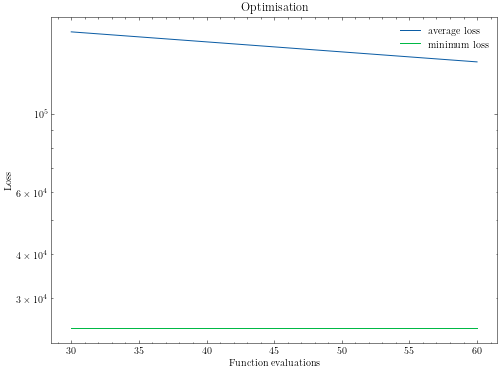

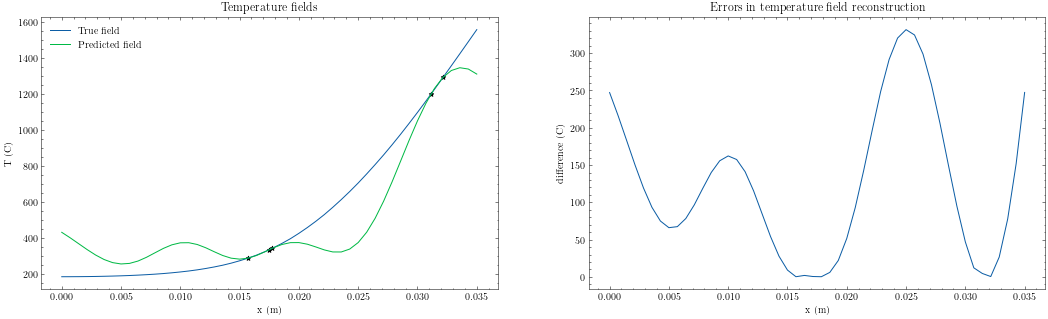

In [5]:
from run_me import *


# Load any objects necessary
pickle_manager = PickleManager()
graph_manager = GraphManager()
true_temp_field = pickle_manager.read_file('simulation', 'field_temp_line.obj')
grid = pickle_manager.read_file('simulation', 'line_temp.obj')

bounds = true_temp_field.get_bounds()
sensor_bounds = bounds + np.array([[1], [-1]])*0.002

# Add the symmetry
symmetry_manager = SymmetryManager()
symmetry_manager.set_1D_x(0.015)

# Setup the sensor suite
def f(x): return 0
sensor = PointSensor(0, f, 0, [-5000, 5000])
sensors = np.array([sensor]*5)
sensor_suite = SensorSuite(
    ScalarField(GPModel, bounds, true_temp_field.get_dim()), 
    sensors,
    symmetry=[symmetry_manager.reflect_1D]
)


# Setup the experiment
optimiser = PSOOptimiser('00:00:10')
experiment = Experiment(
    true_temp_field,
    grid,
    optimiser
)
experiment.plan_soo(
    sensor_suite,
    sensor_bounds
)
res = experiment.design()
proposed_layout, true_temps, model_temps, sensor_values = experiment.get_plotting_arrays(res.X)


# Display the results
graph_manager.draw(graph_manager.build_optimisation(
    res.history
))
graph_manager.draw(graph_manager.build_1D_compare(
    grid,
    proposed_layout,
    sensor_values,
    true_temps,
    model_temps,
))

## Design a 1D experiment with Thermocouple sensors


Now we've swapped the sensors for thermocouples which are noisy, systematically wrong, and have an imperfect range.

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       30 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  3.490270E+04 |  2.043144E+03
     2 |       60 |  0.46765 |       2 |  0.6922 |  2.04673 |  1.95327 |  1.954510E+04 |  2.043144E+03
     3 |       90 |  0.13447 |       3 |  0.4860 |  2.04590 |  1.97199 |  1.044118E+04 |  7.224342E+02
     4 |      120 |  0.07671 |       3 |  0.4487 |  2.03620 |  1.98449 |  5.849249E+03 |  5.288720E+02
     5 |      150 | -2.5E-02 |       3 |  0.3845 |  2.02531 |  1.99581 |  2.307956E+03 |  4.298555E+02
     6 |      180 | -2.1E-02 |       3 |  0.3873 |  2.01447 |  2.00522 |  1.894084E+03 |  3.442382E+02
     7 |      210 | -1.7E-02 |       3 |  0.3897 |  2.00450 |  2.02204 |  1.609150E+03 |  3.171693E+02
     8 |      240 |  0.00371 |       3 |  0.4023 |  1.99150 |  2.03924 |  1.406848E+03 |  1.669227E+02
     9 |      270 |  0.00487 |       3 |  0.4030 |  1.97683 |  2.05285 | 

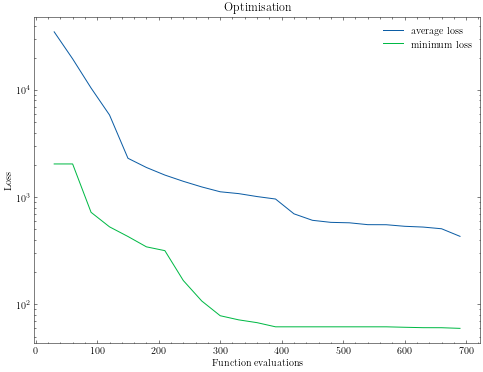

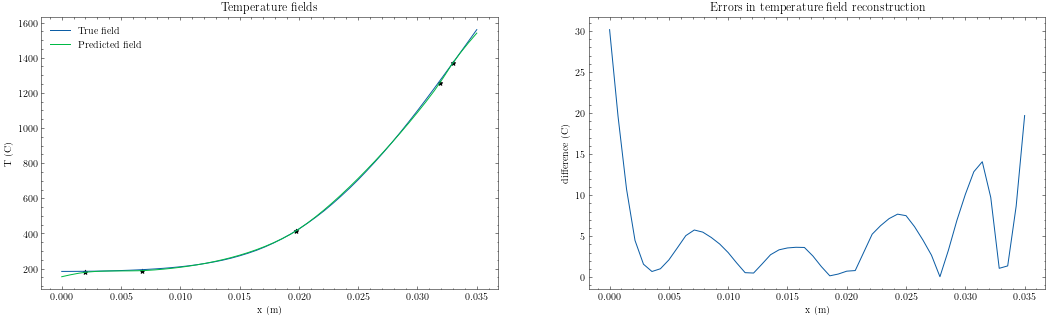

In [6]:
from run_me import *

# Load any objects necessary
pickle_manager = PickleManager()
graph_manager = GraphManager()
true_temp_field = pickle_manager.read_file('simulation', 'field_temp_line.obj')
grid = pickle_manager.read_file('simulation', 'line_temp.obj')

bounds = true_temp_field.get_bounds()
sensor_bounds = bounds + np.array([[1], [-1]])*0.002

# Setup the sensor suite
temps = pickle_manager.read_file('sensors', 'k-type-T.obj')
voltages = pickle_manager.read_file('sensors', 'k-type-V.obj')
sensor = Thermocouple(temps, voltages)
sensors = np.array([sensor]*5)
sensor_suite = SensorSuite(
    ScalarField(RBFModel, bounds, true_temp_field.get_dim()), 
    sensors,
    symmetry=[]
)

# Setup the experiment
optimiser = PSOOptimiser('00:00:10')
experiment = Experiment(
    true_temp_field,
    grid,
    optimiser
)
experiment.plan_soo(
    sensor_suite,
    sensor_bounds
)
res = experiment.design()
proposed_layout, true_temps, model_temps, sensor_values = experiment.get_plotting_arrays(res.X)


# Display the results
graph_manager.draw(graph_manager.build_optimisation(
    res.history
))
graph_manager.draw(graph_manager.build_1D_compare(
    grid,
    proposed_layout,
    sensor_values,
    true_temps,
    model_temps,
))